In [13]:
! pip install pytorch-lightning

In [14]:
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
import pytorch_lightning as pl
from pytorch_lightning.core.lightning import LightningModule
import matplotlib.pyplot as plt
%matplotlib inline

In [15]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [16]:
DIR_PATH = "/kaggle/input/stanford-dogs-dataset/images/Images"

# Modeling

In [17]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.fc = nn.Sequential(
            nn.Conv2d(3, 16, 3, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
#             nn.MaxPool2d(2, stride=2),
            
            nn.Conv2d(16, 32, 3, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.MaxPool2d(2, stride=2),
            
            nn.Conv2d(32, 32, 3, padding=0),
            nn.LeakyReLU(0.2, inplace=True),
#             nn.MaxPool2d(2, stride=2),
            
            nn.Conv2d(32, 64, 5, padding=0),
            nn.LeakyReLU(0.2, inplace=True),
            nn.MaxPool2d(3, stride=2),
            
            nn.Flatten(),
            
            nn.Linear(1024, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 2)
        )
        
    def forward(self, x):
        h = self.fc(x)
#         print ("HIDDEN SIZE: ", h.size())
        return h

In [18]:
class Generator(nn.Module):
    def __init__(self, img_shape):
        super(Generator, self).__init__()
        self.img_shape = img_shape
        self.fc = nn.Sequential(
            nn.Linear(128, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(1024, 3*32*32)
        )
    def forward(self, z):
        img = self.fc(z)
        return img.view(-1, *self.img_shape)

In [19]:
class GAN(LightningModule):

    def __init__(self):
        super().__init__()
        self.generator = Generator((3,32,32))
        self.discriminator = Discriminator()

    def forward(self, x):
        pass

    def prepare_data(self):
        image_transforms = transforms.Compose([
            transforms.Resize((32,32)),
            transforms.ToTensor(),
        ])

        dir_path = '/kaggle/input/'
        data = datasets.ImageFolder(DIR_PATH, transform=image_transforms)
        
        N = len(data)
        indices = list(range(N))
        random.shuffle(indices)
        
        self.train_indices = indices[:int(N*0.7)]
        self.valid_indices = indices[int(N*0.7):int(N*0.85)]
        self.test_indices  = indices[int(N*0.85):]


    def training_step(self, batch, batch_idx, optimizer_idx):
        
        # discriminator
        if optimizer_idx == 0:
            x, label = batch
            x, label = x.to(device), label.to(device)
            label = torch.ones_like(label).to(device)
            y_hat_real = self.discriminator(x)
            real_loss = F.cross_entropy(y_hat_real, label)
            
            z = torch.rand((x.size(0), 128)).to(device)
            label = torch.zeros_like(label).to(device)
            y_hat_fake = self.discriminator(self.generator(z))
            fake_loss = F.cross_entropy(y_hat_fake, label)
            
            loss = real_loss + fake_loss
            
            # logs
            tqdm_dict = {'train_d_loss': loss}
            output = {
                'loss': loss,
                'progress_bar': tqdm_dict,
                'log': tqdm_dict
            }
            return output
        
        # generator
        elif optimizer_idx == 1:
            x, label = batch
            x, label = x.to(device), label.to(device)
            label = torch.ones_like(label).to(device)
            z = torch.rand((x.size(0), 128)).to(device)
            gen_imgs = self.generator(z)
            y_hat = self.discriminator(gen_imgs)
            loss = F.cross_entropy(y_hat, label)
            
            # logs
            tqdm_dict = {'train_g_loss': loss}
            output = {
                'loss': loss,
                'progress_bar': tqdm_dict,
                'log': tqdm_dict
            }
            return output
     
    
    def show_current_generation(self):
        z = torch.rand((1,128)).to(device)
        gen_img = self.generator(z)
        score = self.discriminator(gen_img)
        
        gen_img = gen_img.squeeze().data.cpu()
        img = transforms.ToPILImage()(gen_img).convert("RGB")
        print ("Score of this Generation: ", score)
        plt.imshow(img)
        plt.show()

    def validation_step(self, batch, batch_idx):
        
        # show the first image
        if batch_idx == 0:
            self.show_current_generation()
        
        output = self.training_step(batch, batch_idx, 1)
        return {
            'val_loss': output['loss']
        }
    
    def validation_epoch_end(self, outputs):
        avg_loss = torch.stack([x['val_loss'] for x in outputs]).mean()
        tensorboard_logs = {'val_loss': avg_loss}
        return {'val_loss': avg_loss, 'log': tensorboard_logs}
        
    def configure_optimizers(self):
        opt_generator = torch.optim.Adam(self.generator.parameters(), lr=1e-3)
        opt_discriminator = torch.optim.Adam(self.discriminator.parameters(), lr=1e-3)
        return [opt_discriminator, opt_generator]

    def train_dataloader(self):
        image_transforms = transforms.Compose([
            transforms.Resize((32,32)),
            transforms.ToTensor(),
        ])
        data = datasets.ImageFolder(DIR_PATH, transform=image_transforms)
        train_sampler = SubsetRandomSampler(self.train_indices)
        return DataLoader(data, sampler=train_sampler, batch_size=64)
    
    def val_dataloader(self):
        image_transforms = transforms.Compose([
            transforms.Resize((32,32)),
            transforms.ToTensor(),
        ])
        data = datasets.ImageFolder(DIR_PATH, transform=image_transforms)
        valid_sampler = SubsetRandomSampler(self.valid_indices)
        return DataLoader(data, sampler=valid_sampler, batch_size=64)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type          | Params
------------------------------------------------
0 | generator     | Generator     | 3 M   
1 | discriminator | Discriminator | 328 K 


Score of this Generation:  tensor([[-0.0003, -0.0196]], device='cuda:0')


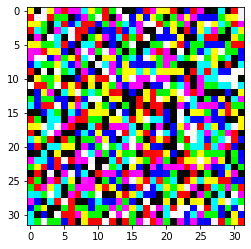

Score of this Generation:  tensor([[-0.1795,  0.2052]], device='cuda:0')


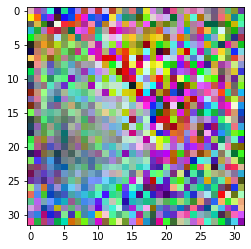

Score of this Generation:  tensor([[-0.0492, -0.0516]], device='cuda:0')


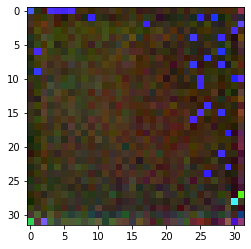

Score of this Generation:  tensor([[-0.2155, -0.2550]], device='cuda:0')


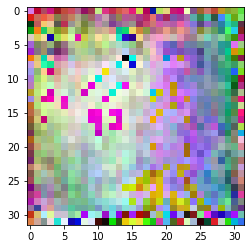

Score of this Generation:  tensor([[ 0.2689, -0.3051]], device='cuda:0')


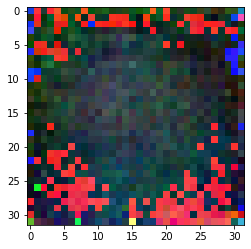

Score of this Generation:  tensor([[-1.7846,  1.3295]], device='cuda:0')


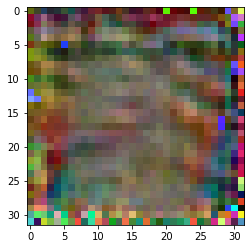

Score of this Generation:  tensor([[ 5.2681, -5.5818]], device='cuda:0')


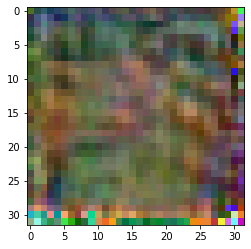

Score of this Generation:  tensor([[-0.2605,  0.2089]], device='cuda:0')


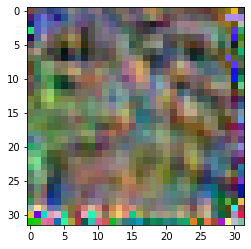

Score of this Generation:  tensor([[ 5.0999, -4.9628]], device='cuda:0')


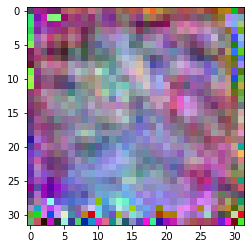

Score of this Generation:  tensor([[ 4.9417, -1.9038]], device='cuda:0')


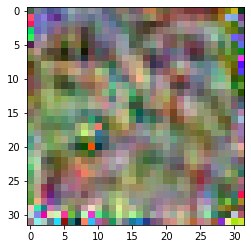

Score of this Generation:  tensor([[ 1.8988, -2.0601]], device='cuda:0')


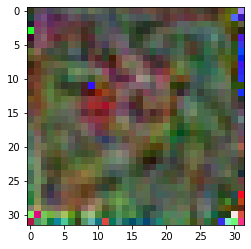

Score of this Generation:  tensor([[ 0.0267, -1.1184]], device='cuda:0')


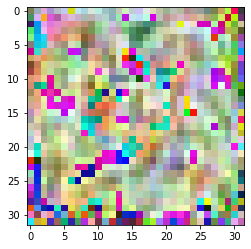

Score of this Generation:  tensor([[ 0.0031, -0.9643]], device='cuda:0')


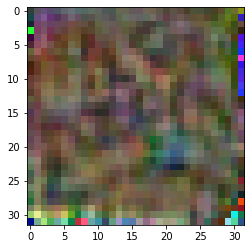

Score of this Generation:  tensor([[-0.1616, -1.2332]], device='cuda:0')


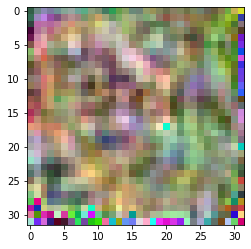

Score of this Generation:  tensor([[ 2.6875, -2.9899]], device='cuda:0')


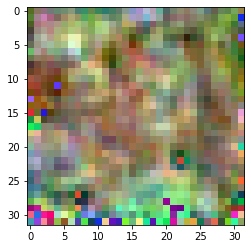

Score of this Generation:  tensor([[ 2.9964, -4.3152]], device='cuda:0')


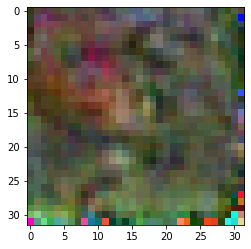

Score of this Generation:  tensor([[ 0.5582, -0.6893]], device='cuda:0')


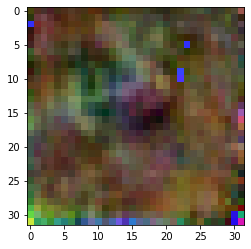

Score of this Generation:  tensor([[ 3.4283, -4.9149]], device='cuda:0')


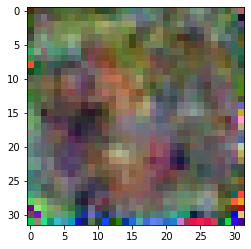

Score of this Generation:  tensor([[ 0.3598, -0.7156]], device='cuda:0')


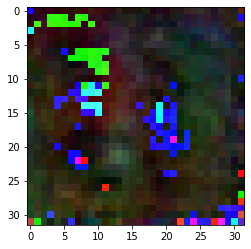

Score of this Generation:  tensor([[ 2.1437, -3.6560]], device='cuda:0')


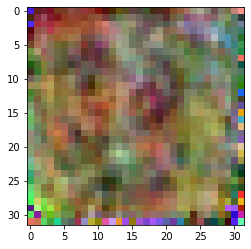

Score of this Generation:  tensor([[ 4.5964, -6.2631]], device='cuda:0')


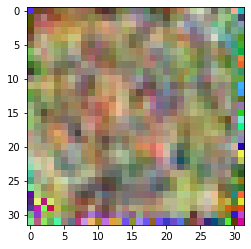

Score of this Generation:  tensor([[ 0.7460, -1.3308]], device='cuda:0')


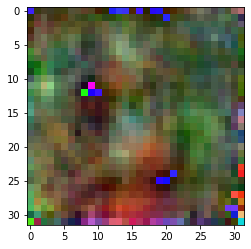

Score of this Generation:  tensor([[ 1.7297, -1.9927]], device='cuda:0')


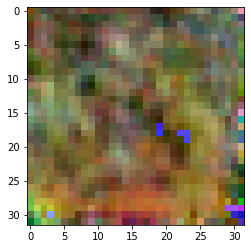

Score of this Generation:  tensor([[ 1.1368, -1.6029]], device='cuda:0')


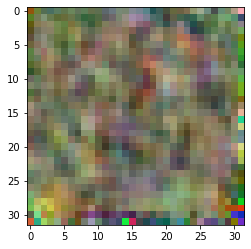

Score of this Generation:  tensor([[ 1.6865, -2.1917]], device='cuda:0')


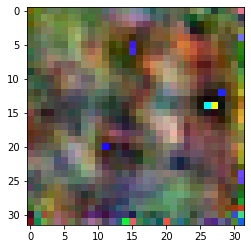

Score of this Generation:  tensor([[ 2.0278, -2.2603]], device='cuda:0')


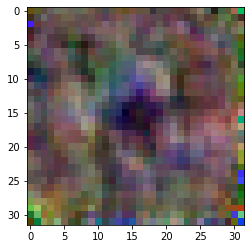

Score of this Generation:  tensor([[ 5.7119, -5.9639]], device='cuda:0')


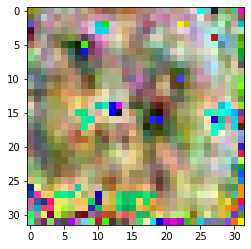

Score of this Generation:  tensor([[ 5.1078, -3.6926]], device='cuda:0')


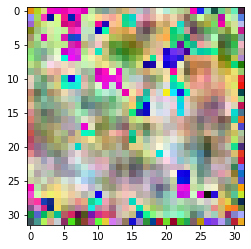

Score of this Generation:  tensor([[ 0.5563, -0.4431]], device='cuda:0')


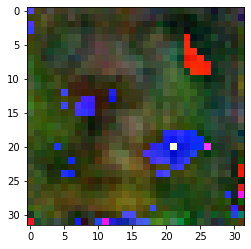

Score of this Generation:  tensor([[-0.8234, -0.3570]], device='cuda:0')


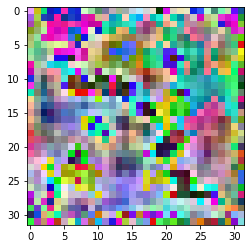

Score of this Generation:  tensor([[ 4.7003, -5.7876]], device='cuda:0')


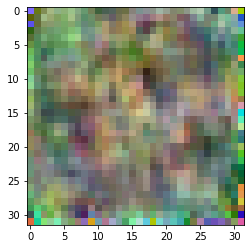

Score of this Generation:  tensor([[ 2.1455, -3.5107]], device='cuda:0')


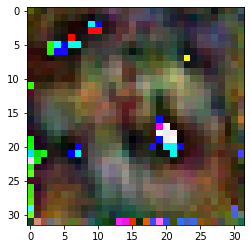

Score of this Generation:  tensor([[2.1449, 0.4672]], device='cuda:0')


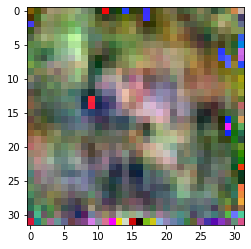

Score of this Generation:  tensor([[ 1.9189, -2.9192]], device='cuda:0')


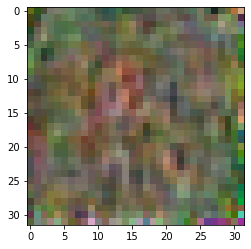

Score of this Generation:  tensor([[ 1.7127, -1.3236]], device='cuda:0')


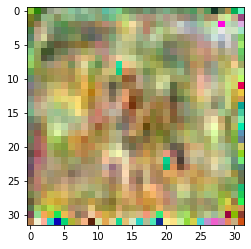

Score of this Generation:  tensor([[ 0.7091, -1.4526]], device='cuda:0')


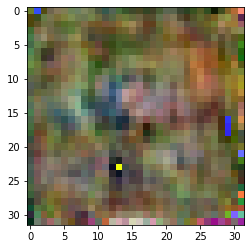

Score of this Generation:  tensor([[ 1.9508, -1.7355]], device='cuda:0')


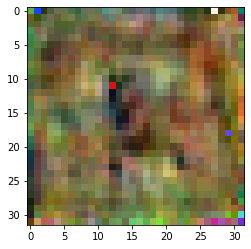

Score of this Generation:  tensor([[ 0.7925, -1.1667]], device='cuda:0')


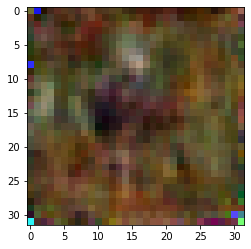

Score of this Generation:  tensor([[ 1.2637, -2.5247]], device='cuda:0')


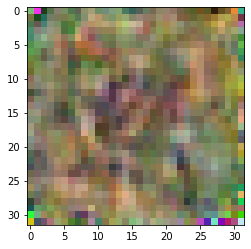

Score of this Generation:  tensor([[ 3.3118, -3.9264]], device='cuda:0')


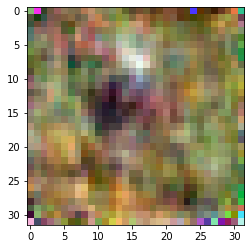

Score of this Generation:  tensor([[ 3.8707, -4.2062]], device='cuda:0')


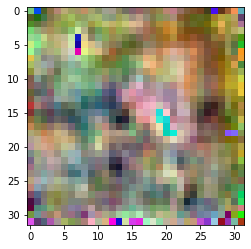

Score of this Generation:  tensor([[ 1.6146, -3.0407]], device='cuda:0')


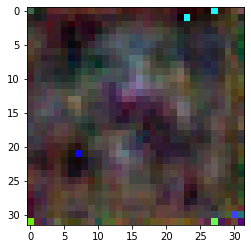

Score of this Generation:  tensor([[ 2.8006, -3.4881]], device='cuda:0')


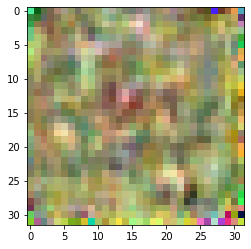

Score of this Generation:  tensor([[ 1.8057, -2.0161]], device='cuda:0')


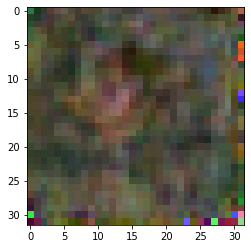

Score of this Generation:  tensor([[ 1.8437, -2.2401]], device='cuda:0')


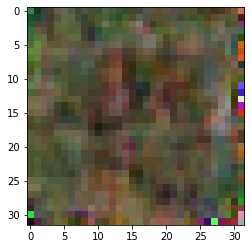

Score of this Generation:  tensor([[ 3.1170, -2.9876]], device='cuda:0')


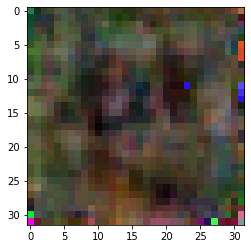

Score of this Generation:  tensor([[ 2.8469, -3.0353]], device='cuda:0')


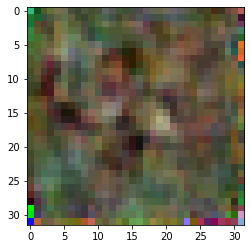

Score of this Generation:  tensor([[ 2.0637, -2.6262]], device='cuda:0')


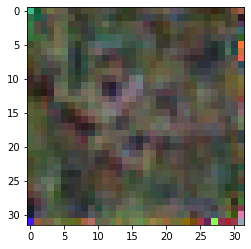

Score of this Generation:  tensor([[ 1.3401, -2.5335]], device='cuda:0')


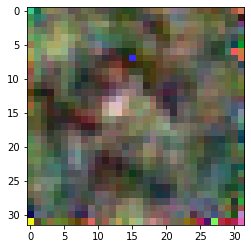

Score of this Generation:  tensor([[ 1.3682, -2.3715]], device='cuda:0')


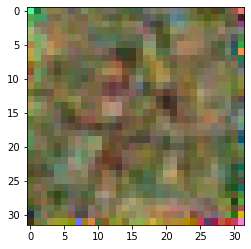

Score of this Generation:  tensor([[ 1.6575, -2.2580]], device='cuda:0')


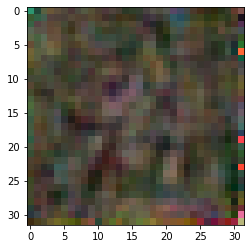

Score of this Generation:  tensor([[ 1.6201, -2.2953]], device='cuda:0')


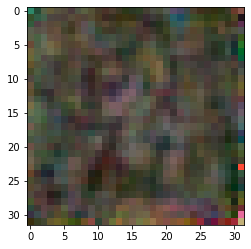

Score of this Generation:  tensor([[ 0.7948, -1.0300]], device='cuda:0')


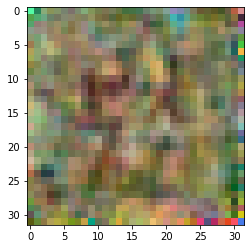

Score of this Generation:  tensor([[ 0.5710, -0.5950]], device='cuda:0')


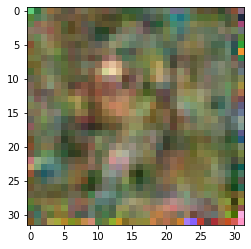

Score of this Generation:  tensor([[ 3.6048, -4.6737]], device='cuda:0')


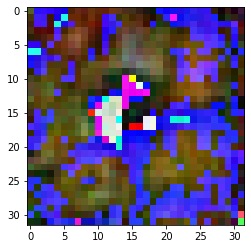

Score of this Generation:  tensor([[ 0.5989, -0.7103]], device='cuda:0')


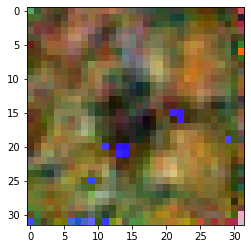

Score of this Generation:  tensor([[ 2.6558, -3.4641]], device='cuda:0')


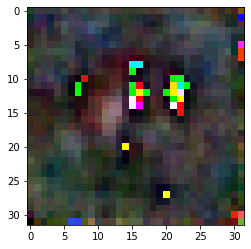

Score of this Generation:  tensor([[ 2.0084, -2.5518]], device='cuda:0')


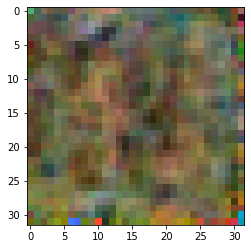

Score of this Generation:  tensor([[ 1.7044, -4.2254]], device='cuda:0')


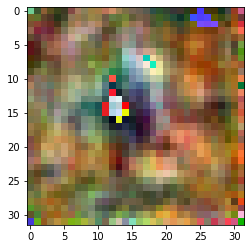

Score of this Generation:  tensor([[ 1.5526, -2.6798]], device='cuda:0')


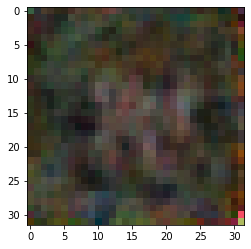

Score of this Generation:  tensor([[ 1.0027, -1.3805]], device='cuda:0')


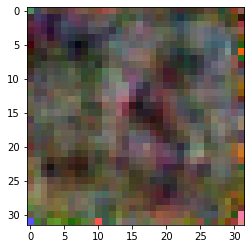

Score of this Generation:  tensor([[ 2.8221, -4.4653]], device='cuda:0')


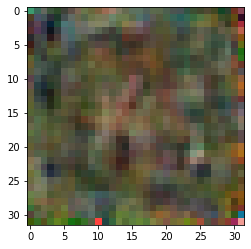

Score of this Generation:  tensor([[ 2.6088, -3.4749]], device='cuda:0')


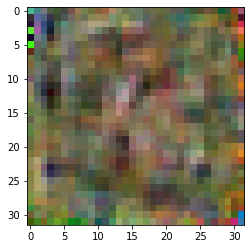

Score of this Generation:  tensor([[ 3.1413, -4.1354]], device='cuda:0')


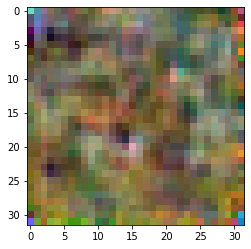

Score of this Generation:  tensor([[ 2.6670, -3.1890]], device='cuda:0')


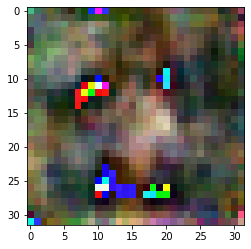

Score of this Generation:  tensor([[ 4.6087, -0.7182]], device='cuda:0')


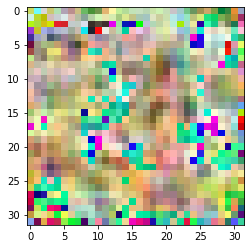

Score of this Generation:  tensor([[ 2.7008, -2.3294]], device='cuda:0')


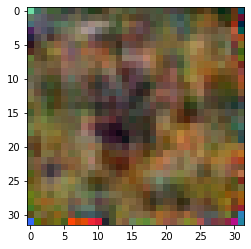

Score of this Generation:  tensor([[ 3.2961, -3.2542]], device='cuda:0')


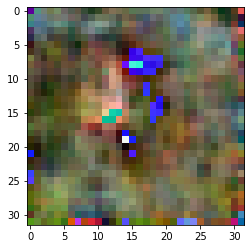

Score of this Generation:  tensor([[ 1.7052, -2.2391]], device='cuda:0')


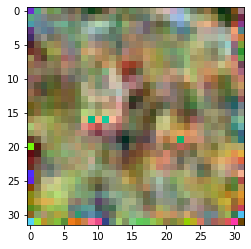

Score of this Generation:  tensor([[ 0.7056, -1.5636]], device='cuda:0')


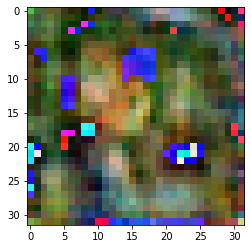

Score of this Generation:  tensor([[ 1.8057, -1.8994]], device='cuda:0')


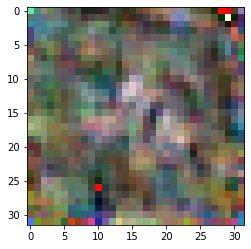

Score of this Generation:  tensor([[ 4.1791, -4.3708]], device='cuda:0')


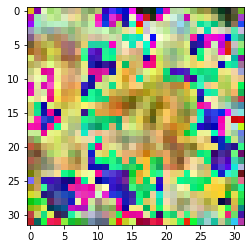

Score of this Generation:  tensor([[ 2.5097, -2.7717]], device='cuda:0')


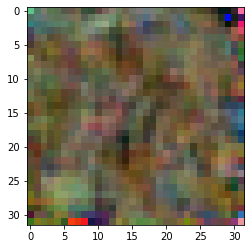

Score of this Generation:  tensor([[ 1.0505, -1.8049]], device='cuda:0')


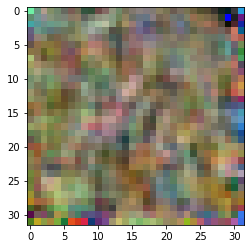

Score of this Generation:  tensor([[1.6686, 0.1282]], device='cuda:0')


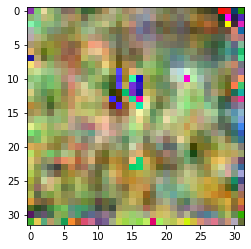

Score of this Generation:  tensor([[ 1.1386, -1.5983]], device='cuda:0')


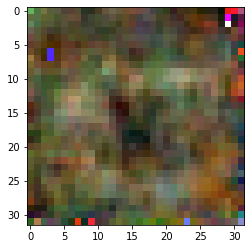

Score of this Generation:  tensor([[ 3.6380, -4.3699]], device='cuda:0')


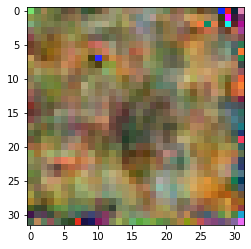

Score of this Generation:  tensor([[ 0.8234, -1.2771]], device='cuda:0')


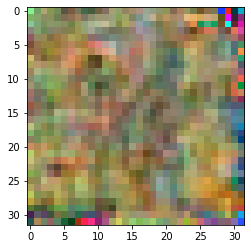

Score of this Generation:  tensor([[ 1.4173, -1.7871]], device='cuda:0')


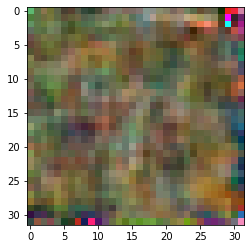

Score of this Generation:  tensor([[ 0.9323, -0.6124]], device='cuda:0')


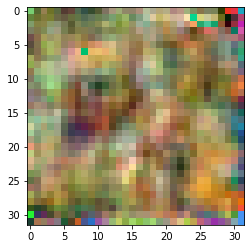

Score of this Generation:  tensor([[ 0.9382, -2.9365]], device='cuda:0')


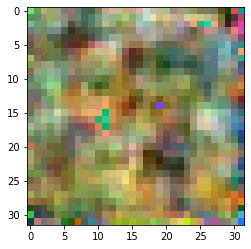

Score of this Generation:  tensor([[ 1.8689, -1.7287]], device='cuda:0')


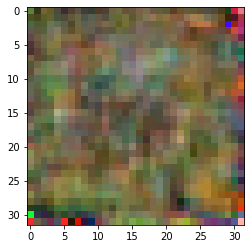

Score of this Generation:  tensor([[ 1.3212, -1.7306]], device='cuda:0')


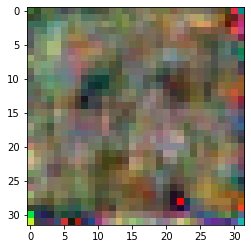

Score of this Generation:  tensor([[ 2.3235, -1.6901]], device='cuda:0')


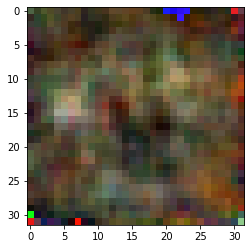

Score of this Generation:  tensor([[ 3.3223, -4.5014]], device='cuda:0')


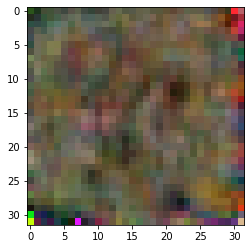

Score of this Generation:  tensor([[ 2.1175, -2.6539]], device='cuda:0')


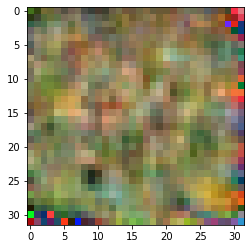

Score of this Generation:  tensor([[ 2.1885, -2.8044]], device='cuda:0')


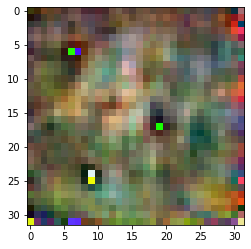

Score of this Generation:  tensor([[ 3.8133, -4.8851]], device='cuda:0')


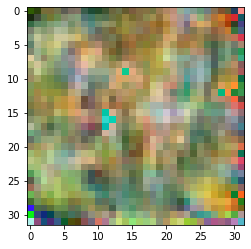

Score of this Generation:  tensor([[ 3.0249, -4.2466]], device='cuda:0')


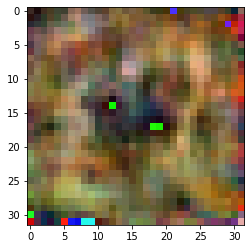

Score of this Generation:  tensor([[ 1.6621, -1.3170]], device='cuda:0')


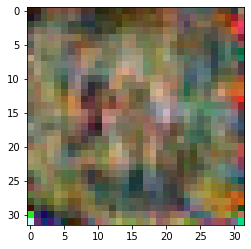

Score of this Generation:  tensor([[ 1.6276, -1.3177]], device='cuda:0')


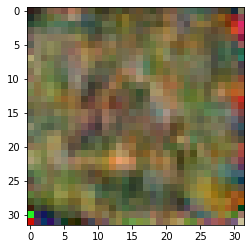

Score of this Generation:  tensor([[ 2.4120, -2.8239]], device='cuda:0')


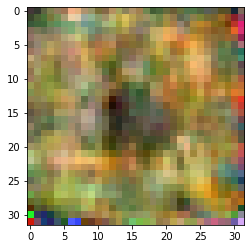

Score of this Generation:  tensor([[ 1.2128, -1.3118]], device='cuda:0')


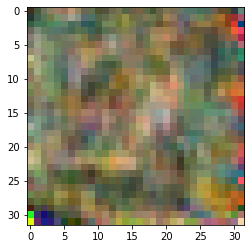

Score of this Generation:  tensor([[ 2.5115, -3.0094]], device='cuda:0')


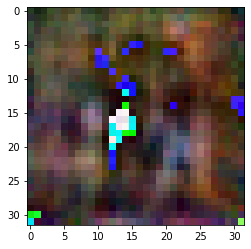

Score of this Generation:  tensor([[ 1.1316, -2.2326]], device='cuda:0')


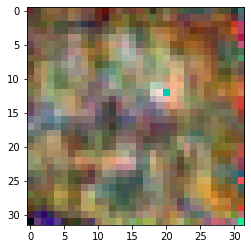

Score of this Generation:  tensor([[ 0.7927, -1.6559]], device='cuda:0')


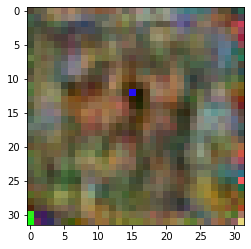

Score of this Generation:  tensor([[ 4.8288, -5.9398]], device='cuda:0')


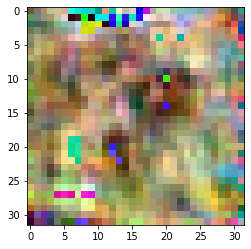

Score of this Generation:  tensor([[ 1.0461, -1.0263]], device='cuda:0')


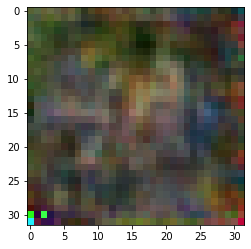

Score of this Generation:  tensor([[-0.0272, -0.3213]], device='cuda:0')


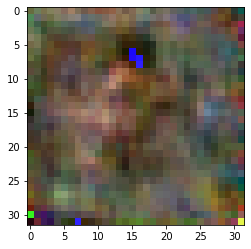

Score of this Generation:  tensor([[ 1.0837, -1.3692]], device='cuda:0')


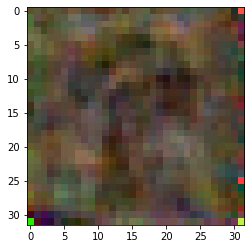

Score of this Generation:  tensor([[ 3.1967, -4.5741]], device='cuda:0')


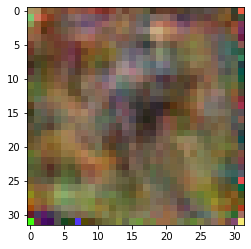

Score of this Generation:  tensor([[ 0.8636, -1.6378]], device='cuda:0')


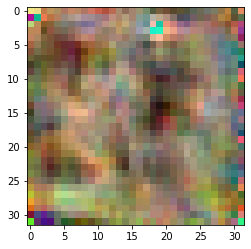

Score of this Generation:  tensor([[ 0.4361, -2.1031]], device='cuda:0')


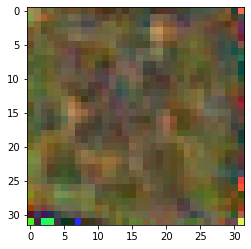

Score of this Generation:  tensor([[ 2.4986, -3.9446]], device='cuda:0')


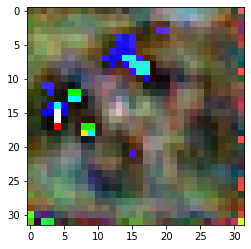

Score of this Generation:  tensor([[ 0.1889, -1.5244]], device='cuda:0')


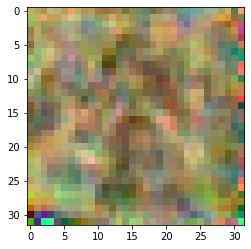

Score of this Generation:  tensor([[ 0.3250, -1.6170]], device='cuda:0')


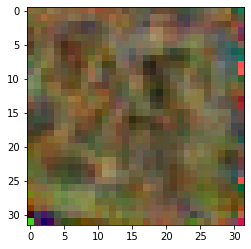

Score of this Generation:  tensor([[ 2.4332, -5.2274]], device='cuda:0')


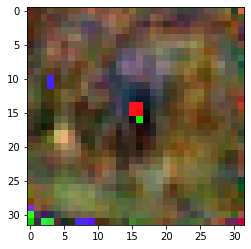

Score of this Generation:  tensor([[ 3.4278, -3.4139]], device='cuda:0')


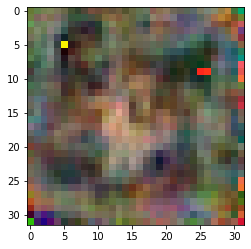

Score of this Generation:  tensor([[ 0.4985, -1.5117]], device='cuda:0')


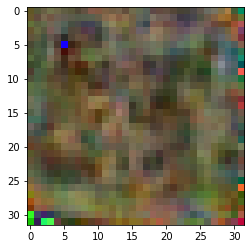

Score of this Generation:  tensor([[ 1.0623, -0.8059]], device='cuda:0')


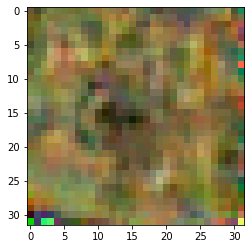

Score of this Generation:  tensor([[ 2.1169, -2.6063]], device='cuda:0')


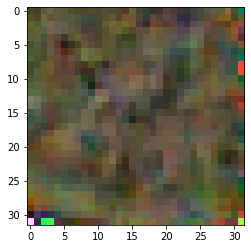

Score of this Generation:  tensor([[ 0.7635, -1.7410]], device='cuda:0')


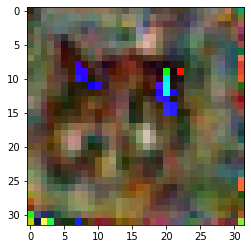

Score of this Generation:  tensor([[ 1.2809, -3.4453]], device='cuda:0')


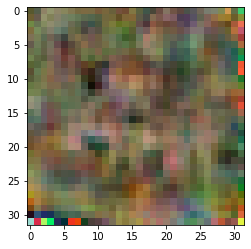

Score of this Generation:  tensor([[ 2.1063, -2.6379]], device='cuda:0')


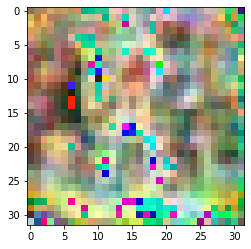

Score of this Generation:  tensor([[-0.4149, -0.5141]], device='cuda:0')


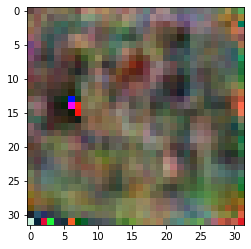

Score of this Generation:  tensor([[ 1.1008, -1.3781]], device='cuda:0')


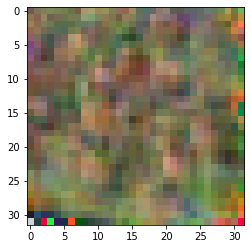

Score of this Generation:  tensor([[ 0.1630, -1.6201]], device='cuda:0')


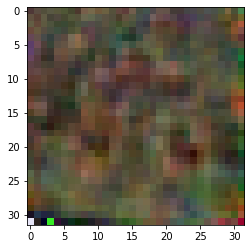

Score of this Generation:  tensor([[ 1.7126, -3.3773]], device='cuda:0')


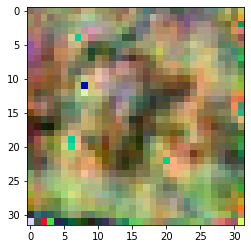

Score of this Generation:  tensor([[ 0.3036, -2.2909]], device='cuda:0')


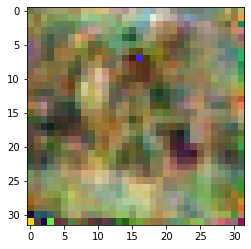

Score of this Generation:  tensor([[ 6.4552, -8.4113]], device='cuda:0')


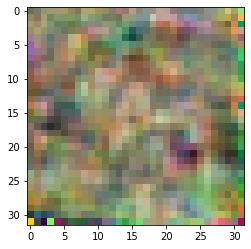

Score of this Generation:  tensor([[ 1.6694, -2.5075]], device='cuda:0')


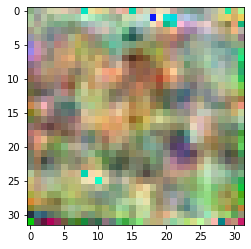

Score of this Generation:  tensor([[ 0.6843, -2.2626]], device='cuda:0')


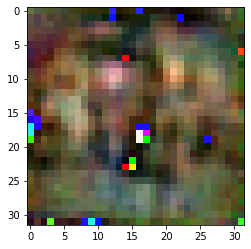

Score of this Generation:  tensor([[ 4.0450, -5.6883]], device='cuda:0')


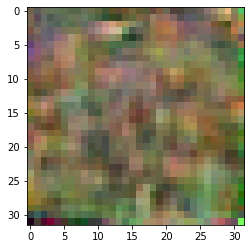

Score of this Generation:  tensor([[ 2.9058, -4.3678]], device='cuda:0')


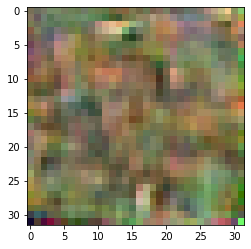

Score of this Generation:  tensor([[-0.1906,  0.1755]], device='cuda:0')


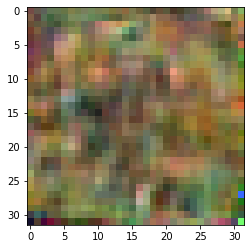

Score of this Generation:  tensor([[-0.5498, -1.4318]], device='cuda:0')


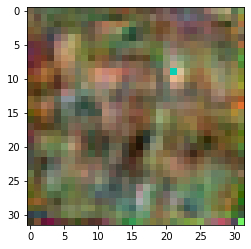

Score of this Generation:  tensor([[ 1.6579, -3.3981]], device='cuda:0')


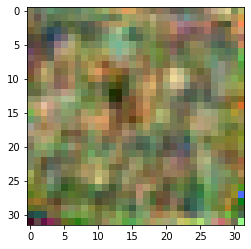

Score of this Generation:  tensor([[ 1.0078, -2.4726]], device='cuda:0')


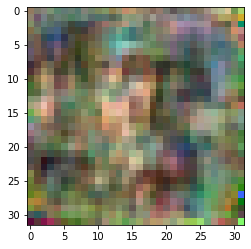

Score of this Generation:  tensor([[ 1.6587, -3.2177]], device='cuda:0')


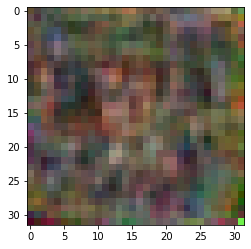

Score of this Generation:  tensor([[ 0.7166, -3.1452]], device='cuda:0')


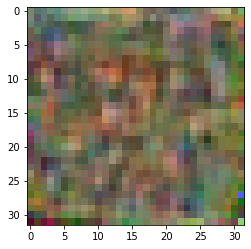

Score of this Generation:  tensor([[ 2.9822, -6.6217]], device='cuda:0')


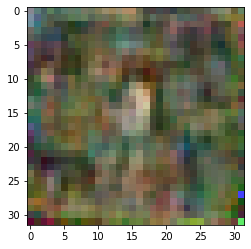

Score of this Generation:  tensor([[ 1.7095, -3.1776]], device='cuda:0')


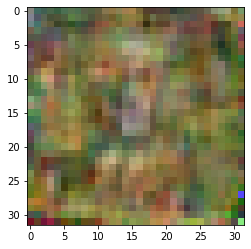

Score of this Generation:  tensor([[ 1.4434, -3.2620]], device='cuda:0')


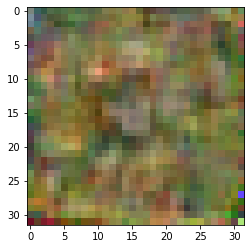

Score of this Generation:  tensor([[ 1.7174, -2.5741]], device='cuda:0')


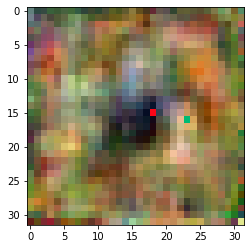

Score of this Generation:  tensor([[ 1.1093, -2.2737]], device='cuda:0')


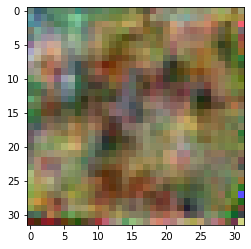

Score of this Generation:  tensor([[ 0.1666, -0.5336]], device='cuda:0')


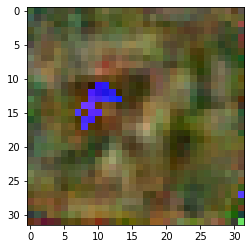

Score of this Generation:  tensor([[ 5.2267, -7.5186]], device='cuda:0')


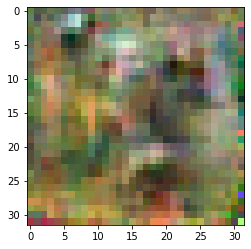

Score of this Generation:  tensor([[ 2.3675, -4.0972]], device='cuda:0')


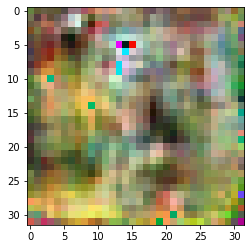

Score of this Generation:  tensor([[ 3.3463, -4.3398]], device='cuda:0')


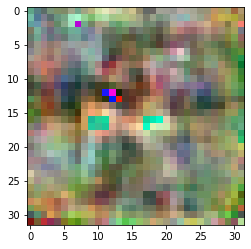

Score of this Generation:  tensor([[ 1.7324, -2.5883]], device='cuda:0')


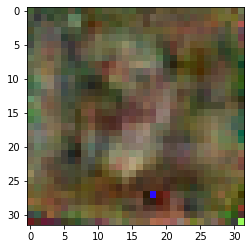

Score of this Generation:  tensor([[ 1.3695, -1.6724]], device='cuda:0')


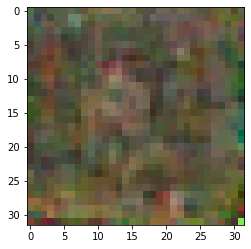

Score of this Generation:  tensor([[ 1.4218, -3.4824]], device='cuda:0')


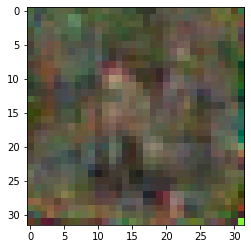

Score of this Generation:  tensor([[ 1.8758, -2.4561]], device='cuda:0')


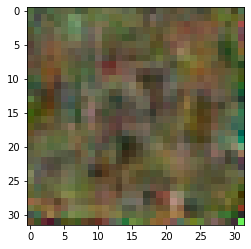

Score of this Generation:  tensor([[ 1.9717, -2.4131]], device='cuda:0')


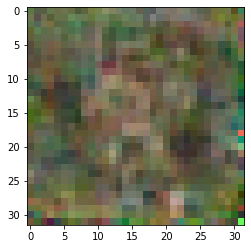

Score of this Generation:  tensor([[ 2.0586, -2.7171]], device='cuda:0')


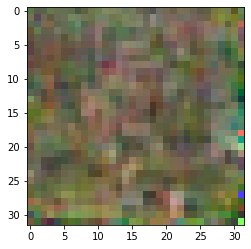

Score of this Generation:  tensor([[ 1.1593, -1.9671]], device='cuda:0')


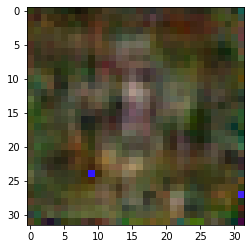

Score of this Generation:  tensor([[ 0.2193, -2.1786]], device='cuda:0')


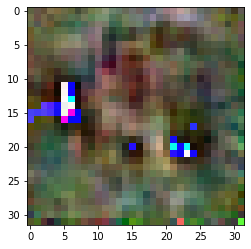

Score of this Generation:  tensor([[ 1.9996, -2.4931]], device='cuda:0')


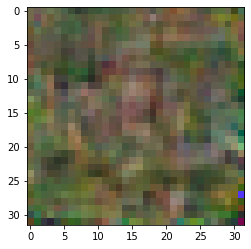

Score of this Generation:  tensor([[ 0.8946, -1.2374]], device='cuda:0')


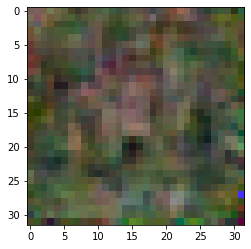

Score of this Generation:  tensor([[ 4.9614, -4.5349]], device='cuda:0')


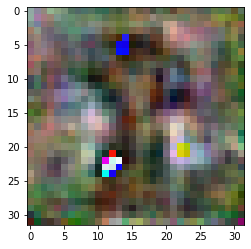

Score of this Generation:  tensor([[ 2.0174, -2.1378]], device='cuda:0')


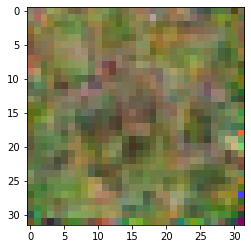

Score of this Generation:  tensor([[ 3.1092, -3.4374]], device='cuda:0')


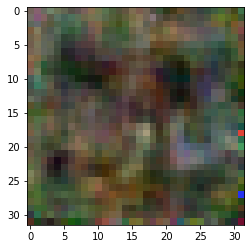

Score of this Generation:  tensor([[ 2.8702, -4.4815]], device='cuda:0')


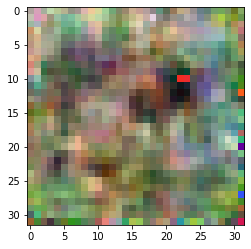

Score of this Generation:  tensor([[ 2.2390, -2.6456]], device='cuda:0')


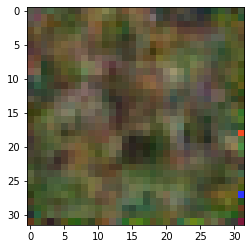

Score of this Generation:  tensor([[ 4.2676, -4.7398]], device='cuda:0')


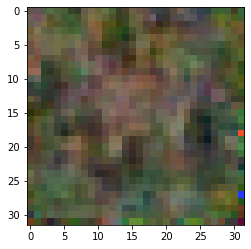

Score of this Generation:  tensor([[ 1.6952, -1.8392]], device='cuda:0')


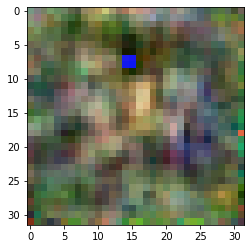

Score of this Generation:  tensor([[ 1.6774, -2.6698]], device='cuda:0')


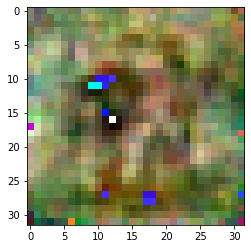

Score of this Generation:  tensor([[ 4.3549, -3.2002]], device='cuda:0')


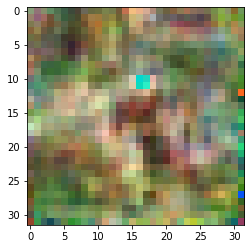

Score of this Generation:  tensor([[ 1.4860, -2.0524]], device='cuda:0')


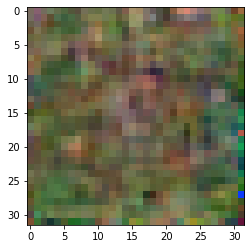

Score of this Generation:  tensor([[ 3.7607, -5.4527]], device='cuda:0')


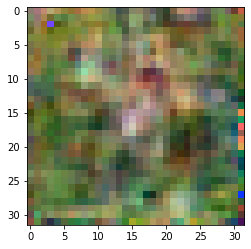

Score of this Generation:  tensor([[-0.2540, -1.6948]], device='cuda:0')


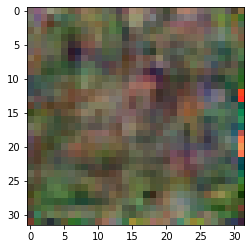

Score of this Generation:  tensor([[ 2.9249, -0.5519]], device='cuda:0')


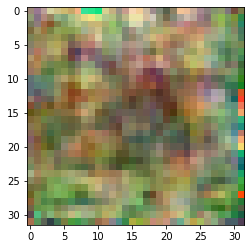

Score of this Generation:  tensor([[1.1629, 1.5004]], device='cuda:0')


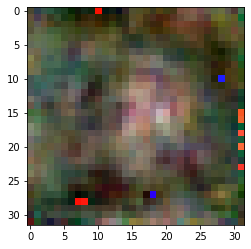

Score of this Generation:  tensor([[ 2.1882, -2.3244]], device='cuda:0')


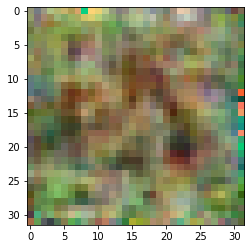

Score of this Generation:  tensor([[ 1.4893, -1.7926]], device='cuda:0')


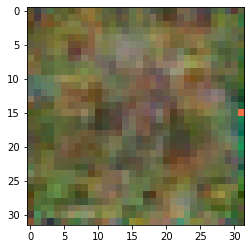

Score of this Generation:  tensor([[ 1.5020, -2.4732]], device='cuda:0')


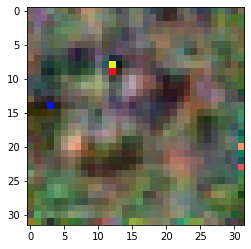

Score of this Generation:  tensor([[-0.0613, -0.5749]], device='cuda:0')


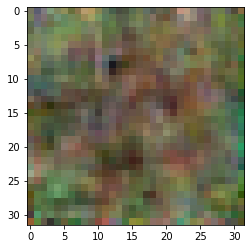

Score of this Generation:  tensor([[ 151.7911, -196.4329]], device='cuda:0')


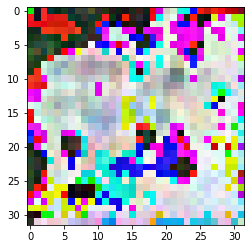

Score of this Generation:  tensor([[ 2.2490, -2.3932]], device='cuda:0')


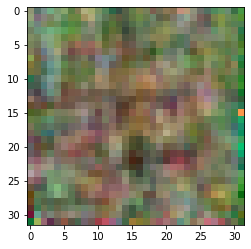

Score of this Generation:  tensor([[ 4.2662, -6.6544]], device='cuda:0')


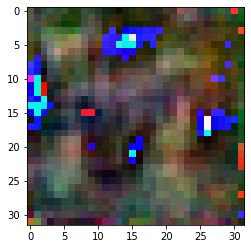

Score of this Generation:  tensor([[ 7.4925, -5.4388]], device='cuda:0')


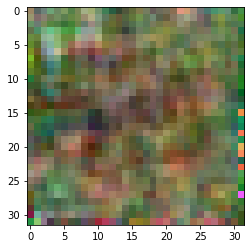

Score of this Generation:  tensor([[ 2.5736, -2.2175]], device='cuda:0')


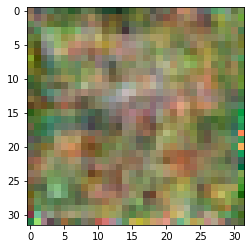

Score of this Generation:  tensor([[ 5.6610, -9.3260]], device='cuda:0')


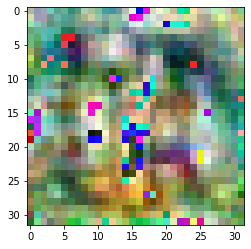

Score of this Generation:  tensor([[ 4.1646, -6.3230]], device='cuda:0')


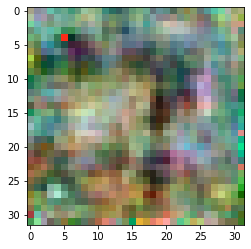

Score of this Generation:  tensor([[ 4.3765, -4.8494]], device='cuda:0')


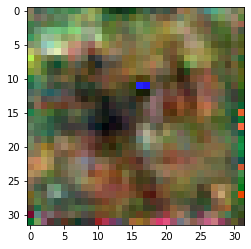

Score of this Generation:  tensor([[ 1.9844, -2.3830]], device='cuda:0')


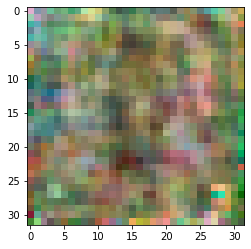

Score of this Generation:  tensor([[ 1.0187, -2.2115]], device='cuda:0')


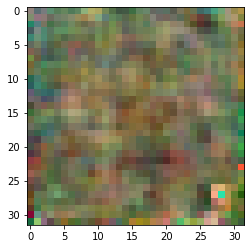

Score of this Generation:  tensor([[ 1.9965, -1.5844]], device='cuda:0')


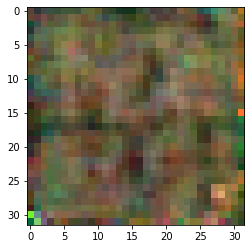

Score of this Generation:  tensor([[ 3.1106, -4.0913]], device='cuda:0')


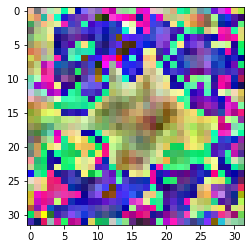

Score of this Generation:  tensor([[ 1.9643, -1.5175]], device='cuda:0')


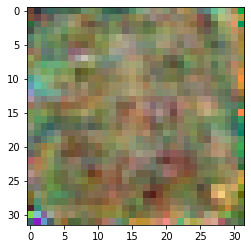

Score of this Generation:  tensor([[ 1.4333, -0.7976]], device='cuda:0')


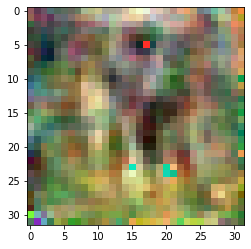

Score of this Generation:  tensor([[ 4.9254, -5.7990]], device='cuda:0')


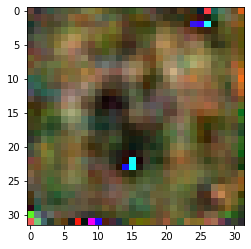

Score of this Generation:  tensor([[ 2.6588, -2.2795]], device='cuda:0')


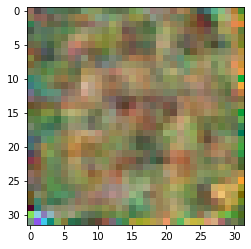

Score of this Generation:  tensor([[ 2.2734, -5.3077]], device='cuda:0')


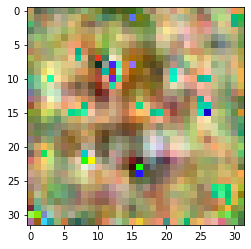

Score of this Generation:  tensor([[ 1.3552, -1.2963]], device='cuda:0')


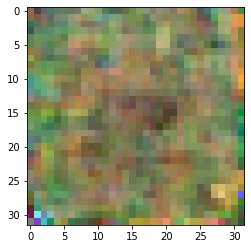

Score of this Generation:  tensor([[ 1.2300, -1.9124]], device='cuda:0')


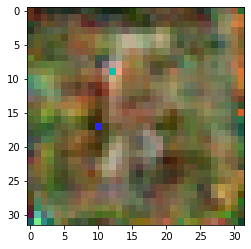

Score of this Generation:  tensor([[ 0.2413, -1.9954]], device='cuda:0')


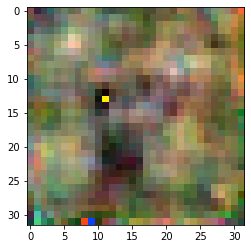

Score of this Generation:  tensor([[ 3.4840, -4.0682]], device='cuda:0')


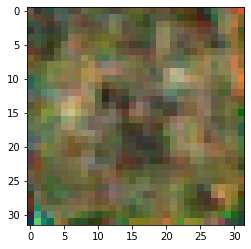

Score of this Generation:  tensor([[ 1.2357, -1.0049]], device='cuda:0')


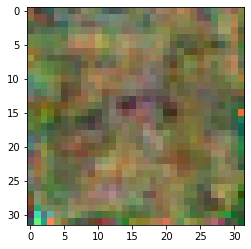

Score of this Generation:  tensor([[ 0.7314, -2.6687]], device='cuda:0')


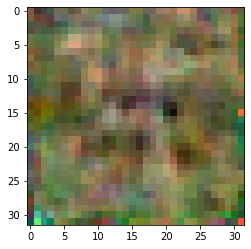

Score of this Generation:  tensor([[ 1.3042, -3.3323]], device='cuda:0')


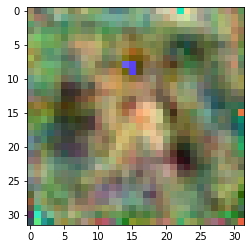

Score of this Generation:  tensor([[ 0.8560, -1.9230]], device='cuda:0')


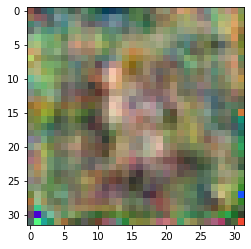

Score of this Generation:  tensor([[ 4.9586, -6.1507]], device='cuda:0')


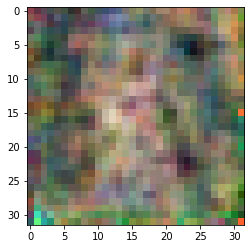

Score of this Generation:  tensor([[ 3.1594, -3.2158]], device='cuda:0')


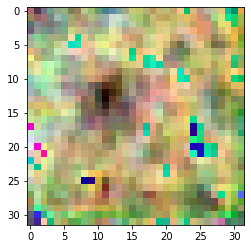

Score of this Generation:  tensor([[ 1.2754, -2.1710]], device='cuda:0')


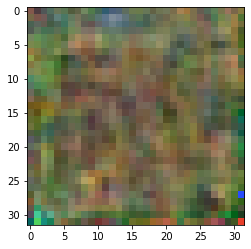

Score of this Generation:  tensor([[ 2.7087, -1.9523]], device='cuda:0')


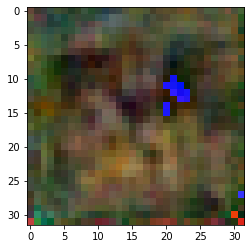

Score of this Generation:  tensor([[  8.0700, -11.2562]], device='cuda:0')


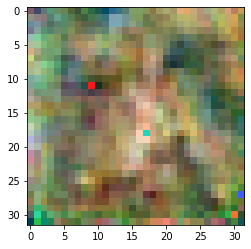

Score of this Generation:  tensor([[ 0.3824, -1.1217]], device='cuda:0')


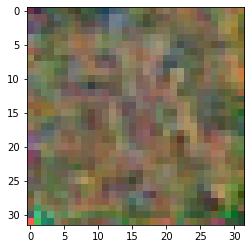

Score of this Generation:  tensor([[ 4.2903, -6.3956]], device='cuda:0')


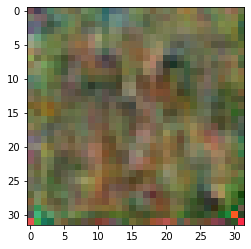

Score of this Generation:  tensor([[ 3.7474, -6.1422]], device='cuda:0')


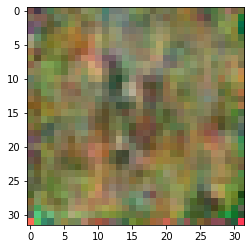

In [ ]:
model = GAN().to(device)
trainer = pl.Trainer(gpus=1)    
trainer.fit(model)